# Titanic Classification (XGBoost)

In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
import seaborn as sns

### Setup

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
#Binarise data, remove useless columns and extract meaningful features
def wrangle(df):
    df["Male"] = df["Sex"].map(lambda x: x == "male")
    df["Pronoun"] = df["Name"].map(lambda x: x.split(", ")[1].split(".")[0])
    df["Prefix"] = df["Ticket"].map(lambda x: x.split(" ")[0].split("/")[0].replace(".", "") if " " in x else "")
    df["Letter"] = df["Cabin"].fillna("00").map(lambda x: x[0])
    df["Family"] = df["SibSp"] + df["Parch"]
    df = df.drop(["PassengerId", "Name", "Ticket", "Sex", "Cabin"], axis=1)
    return df

In [5]:
#One-hot encode the categorical columns for train and test
def encode(X_train, X_test, cat_cols):
    encoder = OneHotEncoder(categories='auto', sparse=False, handle_unknown='ignore')
    encoder.fit(X_train[cat_cols])
    X_train_encoded = encoder.transform(X_train[cat_cols])
    X_train_final = pd.concat([X_train.drop(cat_cols, axis=1), pd.DataFrame(X_train_encoded, index=X_train.index)], axis=1)
    X_test_encoded = encoder.transform(X_test[cat_cols])
    X_test_final = pd.concat([X_test.drop(cat_cols, axis=1), pd.DataFrame(X_test_encoded, index=X_test.index)], axis=1)
    return X_train_final, X_test_final, encoder

### Data Exploration

In [6]:
new_train = wrangle(train)

In [7]:
new_train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,Male,Pronoun,Prefix,Letter,Family
0,0,3,22.0,1,0,7.2500,S,True,Mr,A,0,1
1,1,1,38.0,1,0,71.2833,C,False,Mrs,PC,C,1
2,1,3,26.0,0,0,7.9250,S,False,Miss,STON,0,0
3,1,1,35.0,1,0,53.1000,S,False,Mrs,,C,1
4,0,3,35.0,0,0,8.0500,S,True,Mr,,0,0


In [8]:
#Function that aggregates total counts and survive rates
def aggregate(df, cols):
    by_cols = df.groupby(cols).agg({"Survived":[("Total", "count"), ("Survived", "sum")]})
    by_cols.columns = by_cols.columns.droplevel()
    by_cols["Died"] = by_cols["Total"] - by_cols["Survived"]
    by_cols["Survive Rate"] = 100*by_cols["Survived"]/by_cols["Total"]
    return by_cols.sort_values("Total", ascending=False)

In [9]:
#Higher class has higer survival rates
aggregate(new_train,["Pclass"])

,Total,Survived,Died,Survive Rate
Pclass,,,,
3,491,119,372,24.236253
1,216,136,80,62.962963
2,184,87,97,47.282609


In [10]:
#Women survived more
aggregate(new_train,["Male"])

,Total,Survived,Died,Survive Rate
Male,,,,
True,577,109,468,18.890815
False,314,233,81,74.203822


In [11]:
#Embarking on C had much higher survival rate
aggregate(new_train,["Embarked"])

,Total,Survived,Died,Survive Rate
Embarked,,,,
S,644,217,427,33.695652
C,168,93,75,55.357143
Q,77,30,47,38.961039


In [12]:
#Pronoun is not too informative, already mostly captured by gender and age
aggregate(new_train,["Pronoun"])

,Total,Survived,Died,Survive Rate
Pronoun,,,,
Mr,517,81,436,15.667311
Miss,182,127,55,69.780220
Mrs,125,99,26,79.200000
Master,40,23,17,57.500000
Dr,7,3,4,42.857143
Rev,6,0,6,0.000000
Major,2,1,1,50.000000
Col,2,1,1,50.000000
Mlle,2,2,0,100.000000


In [13]:
#Higher class women had very high survival rates
aggregate(new_train,["Pclass", "Male"])

Total  Survived  Died  Survive Rate
Pclass Male                                      
3      True     347        47   300     13.544669
       False    144        72    72     50.000000
1      True     122        45    77     36.885246
2      True     108        17    91     15.740741
1      False     94        91     3     96.808511
2      False     76        70     6     92.105263

<Axes: xlabel='Age', ylabel='Count'>

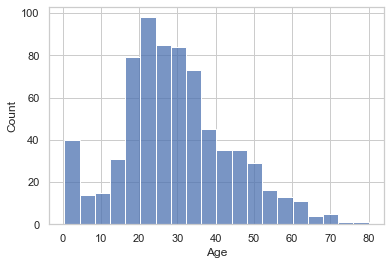

In [14]:
#Plot age distribution
sns.set(style='whitegrid')
sns.despine(left=True)
sns.histplot(new_train["Age"], bins=20)

<Axes: xlabel='Fare', ylabel='Count'>

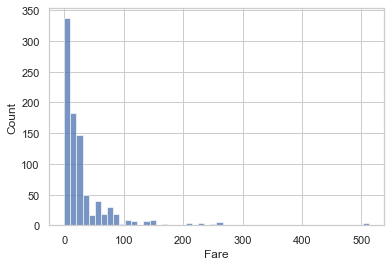

In [15]:
#Plot fare distribution
sns.histplot(new_train["Fare"], bins=50)

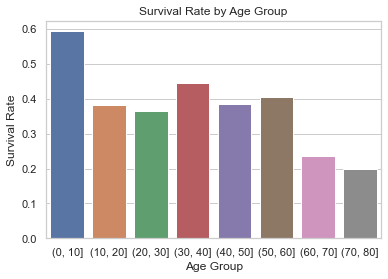

In [16]:
#Younger people had higher survival rates
new_train['AgeGroup'] = pd.cut(new_train['Age'], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80])

age_survival = new_train.groupby(['AgeGroup'])['Survived'].mean().reset_index()

sns.barplot(x='AgeGroup', y='Survived', data=age_survival)

plt.title('Survival Rate by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Survival Rate')
plt.show()

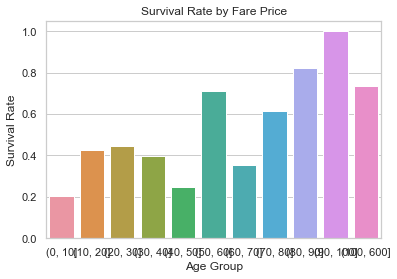

In [17]:
#Higher fares had higher survival rates
new_train['FareGroup'] = pd.cut(new_train['Fare'], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 600])

age_survival = new_train.groupby(['FareGroup'])['Survived'].mean().reset_index()

sns.barplot(x='FareGroup', y='Survived', data=age_survival)

plt.title('Survival Rate by Fare Price')
plt.xlabel('Age Group')
plt.ylabel('Survival Rate')
plt.show()

new_train = new_train.drop(["AgeGroup", "FareGroup"],axis=1)

### Use XGBoost with default parameters

In [18]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    new_train.drop('Survived', axis=1),
    new_train['Survived'],
    test_size=0.2,
    random_state=42
)

In [19]:
cat_cols = ["Embarked", "Pronoun", "Prefix", "Letter"]
X_train_final, X_test_final, encoder = encode(X_train, X_test, cat_cols)

/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [20]:
X_train_final

,Pclass,Age,SibSp,Parch,Fare,Male,Family,0,1,2,...,40,41,42,43,44,45,46,47,48,49
331,1,45.5,0,0,28.5000,True,0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
733,2,23.0,0,0,13.0000,True,0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
382,3,32.0,0,0,7.9250,True,0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
704,3,26.0,1,0,7.8542,True,1,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
813,3,6.0,4,2,31.2750,False,6,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,3,21.0,0,0,7.6500,False,0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
270,1,NaN,0,0,31.0000,True,0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
860,3,41.0,2,0,14.1083,True,2,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
435,1,14.0,1,2,120.0000,False,3,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(X_train_final, y_train)
y_pred = xgb_classifier.predict(X_test_final)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.7932960893854749


### Hyperparameter tuning

In [22]:
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200],
    'gamma': [0, 0.1],
    'colsample_bytree': [0.6, 0.8]
}

xgb_classifier = xgb.XGBClassifier()


grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_final, y_train)

print('Best hyperparameters:', grid_search.best_params_)

Best hyperparameters: {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


In [23]:
best_xgb_classifier = grid_search.best_estimator_
y_pred = best_xgb_classifier.predict(X_test_final)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy with best hyperparameters:', accuracy)

Accuracy with best hyperparameters: 0.8156424581005587


### Train on the full dataset and predict test set survivors

In [24]:
#Prepare test data in the same way as train
new_test = wrangle(test)

In [25]:
#One-hot encode like before
X_train_final, X_test_final, encoder = encode(new_train.drop("Survived", axis=1), new_test, cat_cols)
y_train = new_train["Survived"]

/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [26]:
#Train best hyperparameters on full labelled dataset
xgb_classifier = xgb.XGBClassifier()

grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_final, y_train)

final_xgb_classifier = grid_search.best_estimator_
print('Best hyperparameters:', grid_search.best_params_)

Best hyperparameters: {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}


In [27]:
#DTop 10 most important features - Pronouns seem important, probably used as a proxy for gender
importance = final_xgb_classifier.feature_importances_
features = X_train_final.columns
encodings = encoder.get_feature_names_out()
translated = []
for feature in features:
    if feature in range(len(encodings)):
        translated.append(encodings[feature])
    else:
        translated.append(feature)
df_importance = pd.DataFrame({'Feature': translated, 'Importance': importance}).sort_values('Importance', ascending=False)
df_importance.head(10)

,Feature,Importance
22,Pronoun_Mr,0.322487
25,Pronoun_Rev,0.100436
5,Male,0.099220
0,Pclass,0.067948
52,Letter_0,0.035863
19,Pronoun_Miss,0.031607
14,Pronoun_Dr,0.029952
54,Letter_B,0.029798
18,Pronoun_Master,0.022879
23,Pronoun_Mrs,0.021176


In [28]:
#Predict test set survivals
y_pred = final_xgb_classifier.predict(X_test_final)

In [29]:
#Export to csv and display
prediction = pd.DataFrame()
prediction["PassengerId"] = test["PassengerId"]
prediction["Survived"] = y_pred
prediction.to_csv("prediction.csv", index=False)
prediction

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
